# What Makes an Airbnb House Expensive in New York?

## Introduction

New York City is one of the most well-known metropolises in North America. Every year, visitors all around the world traveled to New York City for various purposes. During their stays in New York, some of them often use Airbnb, an America-based company that offers short-term homestay deals for its users, to find a place to reside. Many visitors choose to use Airbnb rather than staying in hotels because it offers a larger set of selections of houses at a relatively cheaper price.

As Airbnb users, including those who would like to rent a house and those who wish to benefit from renting their houses, one of their biggest interests is the price of deals. By simple economical knowledge, the price is determined by the demand for houses and the supply of houses, so for those houses that are at higher demand, their prices tend to be more expensive. Factors contributing to expensive rental prices include the house's location, capacity, room type, user ratings and so on. Usually, larger and more independent houses tend to be at higher demand and more expensive. 

The data used to conduct this analysis is from Airbnb Open Data (original website: http://insideairbnb.com/), which has been scraped and made public on Kaggle by an user named DGOMONOV (link to Kaggle: https://www.kaggle.com/datasets/dgomonov/new-york-city-airbnb-open-data). The dataset contains metadata about 48,896 real houses in New York City in 2019, which includes important variables such like their prices, minimum number of days of stays, geographical locations, neighboorhood name, availability throughout the year, room type, number of reviews and number of listings. These variables can be used to conduct analysis that answers the main research question, that is, what makes a house expensive on Airbnb. The findings that answers the research question can be helpful to users on Airbnb, including those planning to travel to New York City (so that they can better make their budgets) and those who own houses in New York City (so that they can benefit more from setting reasonable prices). 

## Data Cleaning and Loading

In [175]:
# Import modules
import pandas as pd
from IPython.display import display 
import matplotlib.colors as mplc
import matplotlib.patches as patches
import matplotlib.pyplot as plt

# Set display format
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [176]:
# Read dataset
ny2019_airbnb_raw = pd.read_csv("AB_NYC_2019.csv")

In [177]:
# Display basic information about this dataset
ny2019_airbnb_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48895 entries, 0 to 48894
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              48895 non-null  int64  
 1   name                            48879 non-null  object 
 2   host_id                         48895 non-null  int64  
 3   host_name                       48874 non-null  object 
 4   neighbourhood_group             48895 non-null  object 
 5   neighbourhood                   48895 non-null  object 
 6   latitude                        48895 non-null  float64
 7   longitude                       48895 non-null  float64
 8   room_type                       48895 non-null  object 
 9   price                           48895 non-null  int64  
 10  minimum_nights                  48895 non-null  int64  
 11  number_of_reviews               48895 non-null  int64  
 12  last_review                     

From the above information summary outputted by Python, we can learn the data type of each variable from the Dtype column. Firstly, we learned that the variable indicating convert the data type of last review from an object to datetime, so that we can quantify date measurements. 

Also, we can discover that there is a gigantic number (about 10,000) missing values for some variables, namely the number of reviews per month and the date of last review. Dropping the observations with missing values is an option to take; however, we will lose about one fifth of data if we do so. Therefore, in order to avoid biased estimation due to dropping too many observations, we will proceed by dropping the variable that gives the number of reviews per month, since part of the information is captured in the variable number of reviews, which had a complete set. Alternatively, if we proceed and conduct regression analysis using number of monthly reviews and total reviews as explanatory variables, these variables will be highly correlated and might result in high multi-collinearity issue. Therefore, we decided to drop the variable (the number of monthly reviews). 

As for the rest of small numbers of missing values in name and host name, since we are not planning to do natural language processing and do not intend to include these categorical variables in the regression model, the problem of missing value can be neglected and we will proceed by removing these variables.

In [178]:
# Get a copy of the original dataset
ny2019_airbnb_raw_copy = ny2019_airbnb_raw.copy()

# Change the datatype of last review from object to datetime
ny2019_airbnb_raw_copy['last_review'] =  pd.to_datetime(ny2019_airbnb_raw_copy['last_review'])

# Drop the variables which we are not going to use
ny2019_airbnb_clean =  ny2019_airbnb_raw_copy.drop(
    ['id', 'name', 'host_id', 'host_name', 'reviews_per_month'], axis = 1)

In [179]:
# Display some data to get a sense about data
ny2019_airbnb_clean.head()

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,calculated_host_listings_count,availability_365
0,Brooklyn,Kensington,40.65,-73.97,Private room,149,1,9,2018-10-19,6,365
1,Manhattan,Midtown,40.75,-73.98,Entire home/apt,225,1,45,2019-05-21,2,355
2,Manhattan,Harlem,40.81,-73.94,Private room,150,3,0,NaT,1,365
3,Brooklyn,Clinton Hill,40.69,-73.96,Entire home/apt,89,1,270,2019-07-05,1,194
4,Manhattan,East Harlem,40.80,-73.94,Entire home/apt,80,10,9,2018-11-19,1,0


Based on the above displays of data, it would be appropriate to choose price as a response variable. Price is a continuous numerical random variable, and it might be interesting to airbnb users and house owners to get information about what makes a house more expensive for staying. The following factors may be related with housing price:
- Neighbourhood, as some neighbourhood may be more expensive in housing than others
- Location (latitude and longitude), yet these factors are difficult to fit and interpret in a regression model, so I would not choose them as explanatory variables in regression.
- Room type, as some room types (full house versus single room) may be more expensive due to their size differences.
- Minimum nights, as some houses requiring multiple nights at appointment may be more or less expensive.
- Date of last review, as houses having more recent reviews might be more popular, so more or less expensive.
- Reviews per month, as as houses having more reviews might be more popular, so more or less expensive.
- Number of listings, as houses with more listings might be more popular, so more orless expensive.
- Availability, as houses that are more available might be more prefered by users, so more expensive.

Looking at the above variables, we can already detect some possible correlation among explanatory variables. We will take a more detailed look at possible collinearity in modeling sections.

Moving on, we will take a more detailed look at the response and explanatory variables using tables and plots.

## Summary Statistics Tables

In [181]:
# Get a new dataset that only has numerical variables
ny2019_airbnb_reg = ny2019_airbnb_clean.drop(['latitude', 'longitude'], axis = 1)
ny2019_airbnb_reg_display = ny2019_airbnb_reg.copy().rename(
    columns={"minimum_nights": "minimum nights", 
             "number_of_reviews": "number of reviews",
             "calculated_host_listings_count": "number of host listings",
             "availability_365": "available days"})

# Brief numerical summary of data
ny2019_airbnb_reg_display.describe()

,price,minimum nights,number of reviews,number of host listings,available days
count,48895.00,48895.00,48895.00,48895.00,48895.00
mean,152.72,7.03,23.27,7.14,112.78
std,240.15,20.51,44.55,32.95,131.62
min,0.00,1.00,0.00,1.00,0.00
25%,69.00,1.00,1.00,1.00,0.00
50%,106.00,3.00,5.00,1.00,45.00
75%,175.00,5.00,24.00,2.00,227.00
max,10000.00,1250.00,629.00,327.00,365.00


The above table contains the summary statistics of the variables of interest.

The first row displays the number of valid observations for each numerical variable, and we can realize that, except for the number of reviews per month, all variables have 48895 observations, which is a fairly large sample size. However, there are about 10,000 missing data in the number of reviews per month, so we may need to decide later on how to treat these missing data.

The second row is the average number for each variable. Taking the response variable price as an example, the average price of staying per night in houses registered at Airbnb in 2019 in New York was 152.72 US dollars. It was interesting to realize that, the average minimum number of nights required to stay is a week, and the average available days per year is 131.6 days. This indicates that not a lot of houses allow users to stay for one or two nights, and there are lots of houses that are not available throughout the year. 

The third row is the standard deviation, which is a measurement of how spread out is the variable. It was interesting to note that most variables, including price, number of minimum nights, number of host listings, and availability are quite spread out, meaning that there are minorities of extreme values in the dataset. This might post threat to validity of the regression model due to possible existance of outliers, which we will investigate later on.

The other rows display the minimum and maximum value for each variable, as well as their quantiles. These measurements again inform us about the spread of data, yet they can be more effectively communicated by using visualizations, which we will cover in the graphical data analysis part.

Moving on, we will investigate the levels in important categorical variables; that is, neighbourhood and room type.

In [163]:
# Get the number of levels in room type
len(ny2019_airbnb_raw_copy['room_type'].unique())

3

What we wanna check here is that the number of levels is appropriate, meaning that the number is not large; otherwise there will be problems with having too less observations to give signficant result for each level. Here the number of distinct room types is 3, so we can proceed.

In [191]:
# Drop unnessary variables (variables that are not numerical)
ny2019_airbnb_by_room_type = ny2019_airbnb_clean.copy().drop(
    ['latitude', 'longitude', 'neighbourhood', 'neighbourhood_group', 'last_review'], axis = 1)
# Group by room type and compute the average
ny2019_airbnb_group_room = ny2019_airbnb_by_room_type.groupby('room_type').mean()
# Group by room type and compute the number of observations
ny2019_airbnb_group_room_count = ny2019_airbnb_by_room_type.groupby('room_type')['price'].count().rename('count')
# Join the grouped datasets
ny2019_airbnb_group_room_full = pd.merge(ny2019_airbnb_group_room, 
                                        ny2019_airbnb_group_room_count, on = 'room_type')
# Sort the grouped dataset by ascending order and display the table
ny2019_airbnb_group_room_full = ny2019_airbnb_group_room_full.sort_values(by = 'price', ascending = True)

ny2019_airbnb_group_room_display = ny2019_airbnb_group_room_full.copy().reset_index().rename(
    columns={"room_type": "room type",
             "minimum_nights": "minimum nights", 
             "number_of_reviews": "number of reviews",
             "calculated_host_listings_count": "number of host listings",
             "availability_365": "available days"})
ny2019_airbnb_group_room_display = ny2019_airbnb_group_room_display.set_index('room type')
ny2019_airbnb_group_room_display

,price,minimum nights,number of reviews,number of host listings,available days,count
room type,,,,,,
Shared room,70.13,6.47,16.60,4.66,162.00,1160
Private room,89.78,5.38,24.11,3.23,111.20,22326
Entire home/apt,211.79,8.51,22.84,10.70,111.92,25409


From the above table, we can discover that, the most expensive room type is entire home or apartment (on average 211.79 US dollars per night), followed by private room (on average 89.78 US dollars per night) and shared room (on average 70.13 US dollars per night). This finding makes sense since larger and more independent room types tend to be at higher demand and more expensive. It is also worth noting that, the number of observations for shared room is very small (1160 observations) compared with the other two, yet they are on average more available for booking. 

Moving on, we will repeat the same procedure for neighbourhoods.

In [128]:
# Get the number of levels in neighbourhood
len(ny2019_airbnb_raw_copy['neighbourhood'].unique())

221

Note that, having 221 levels for neighbourhood would be too much, and it is difficult to generate summarative tables and plots for 221 levels altogether. As a result, we will consider using neighbourhood group to summarize neighbourhood levels from this point.

In [129]:
# Get the number of levels in neighbourhood group
len(ny2019_airbnb_raw_copy['neighbourhood_group'].unique())

5

The number of levels for neighbourhood as 5 is reasonable, so we will proceed by using neighbourhood group instead of neighbourhood.

In [189]:
# Drop unnessary variables (variables that are not numerical)
ny2019_airbnb_by_neighbourhood = ny2019_airbnb_clean.copy().drop(
    ['latitude', 'longitude', 'neighbourhood', 'room_type', 'last_review'], axis = 1)
# Group by room type and compute the average
ny2019_airbnb_group_neighbor = ny2019_airbnb_by_neighbourhood.groupby('neighbourhood_group').mean()
# Group by room type and compute the number of observations
ny2019_airbnb_group_neighbor_count = \
    ny2019_airbnb_by_neighbourhood.groupby('neighbourhood_group')['price'].count().rename('count')
# Join the grouped datasets
ny2019_airbnb_group_neighbor_full = pd.merge(ny2019_airbnb_group_neighbor, 
                                             ny2019_airbnb_group_neighbor_count, on = 'neighbourhood_group')
# Sort the grouped dataset by ascending order and display the table
ny2019_airbnb_group_neighbor_full = \
    ny2019_airbnb_group_neighbor_full.sort_values(by='price',ascending=True)

ny2019_airbnb_group_neighbor_display = ny2019_airbnb_group_neighbor_full.copy().reset_index().rename(
    columns={"neighbourhood_group": "neighbourhood",
             "minimum_nights": "minimum nights", 
             "number_of_reviews": "number of reviews",
             "calculated_host_listings_count": "number of host listings",
             "availability_365": "available days"})
ny2019_airbnb_group_neighbor_display = ny2019_airbnb_group_neighbor_display.set_index('neighbourhood')
ny2019_airbnb_group_neighbor_display

,price,minimum nights,number of reviews,number of host listings,available days,count
neighbourhood,,,,,,
Bronx,87.50,4.56,26.00,2.23,165.76,1091
Queens,99.52,5.18,27.70,4.06,144.45,5666
Staten Island,114.81,4.83,30.94,2.32,199.68,373
Brooklyn,124.38,6.06,24.20,2.28,100.23,20104
Manhattan,196.88,8.58,20.99,12.79,111.98,21661


From the above summarative table, we can identify the rank of average price of 5 neighbourhoods in New York City, where the most expensive neighbourhood is Manhattan (on average 196.88 US dollars per night), followed by Brooklyn (124.38 US dollars), Staten Island (114.81 US dollars), Queens (99.52 US dollars) and Bronx (87.50 US dollars). It is worth noting that the neighborhoods Staten Island and Bronx have a relatively small number of observations, which might result in bias in estimation due to samples being not representative. Also, the most expensive neighborhood, Manhattan, has the largest numbers of minimum nights, host listing and number of observations, which indicates that it is indeed the most popular neighborhood.

We will next move on to the graphical analysis part.

## Plots, Histograms, Figures

Text(0.5, 1.0, 'Distribution of Price of Airbnb per Night in New York')

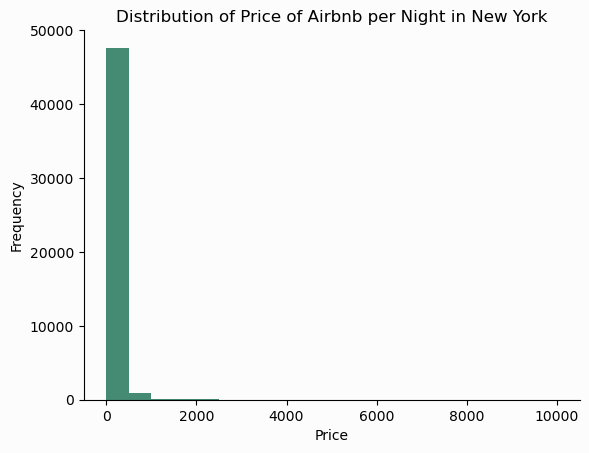

In [169]:
# Graphical Analysis
# Plot a histogram for response variable - price
fig, ax = plt.subplots()
ny2019_airbnb_reg.plot(
    kind="hist", y="price", color='#458B74', bins = 20,
    legend=False, ax=ax
)
# Specify colors and labels
bgcolor = (0.99, 0.99, 0.99)
ax.set_facecolor(bgcolor)
fig.set_facecolor(bgcolor)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Price')
ax.set_ylabel('Frequency')
ax.set_title("Distribution of Price of Airbnb per Night in New York")

The above histogram shows the distribution of price of all houses involved in the dataset, and we can realize that the distribution is extremely skewed to the right. While the vast majority of houses have their price in between 0 to 100 US dollars per night, there are some minorities of expensive houses having prices between 2000 to 10000. These extremely expensive houses can be considered outliers, and may post threat to model validation when it comes to regression. Possible solutions include using robust standard errors, or using more advanced way of modeling such as penalized regression, to address the issue with outliers. 

Text(0.5, 1.0, 'Distribution of Price by Room Type in NYC')

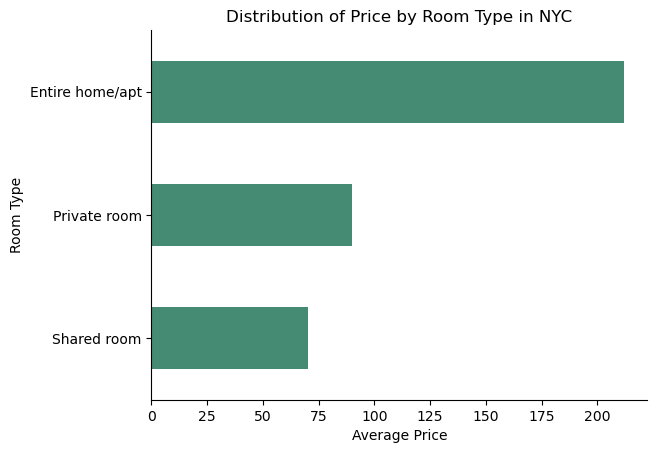

In [170]:
# Plot a barplot on average prices of room types
fig, ax = plt.subplots()
ny2019_airbnb_group_room_full["price"].plot(kind="barh", ax=ax, color='#458B74')

# Specify labels and polishing
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Average Price')
ax.set_ylabel('Room Type')
ax.set_title("Distribution of Price by Room Type in NYC")

The above barplot is a visualization of average price for different room types, and we can directly visualize that houses rented entirely are about more than two times more expensive than a private room or shared room. Such finding supports that room type is a predictive factor at capturing the variation in house prices, so room type should definitely be involved in regression modeling.

Text(0.5, 1.0, 'Distribution of Price by Neighbourhood in NYC')

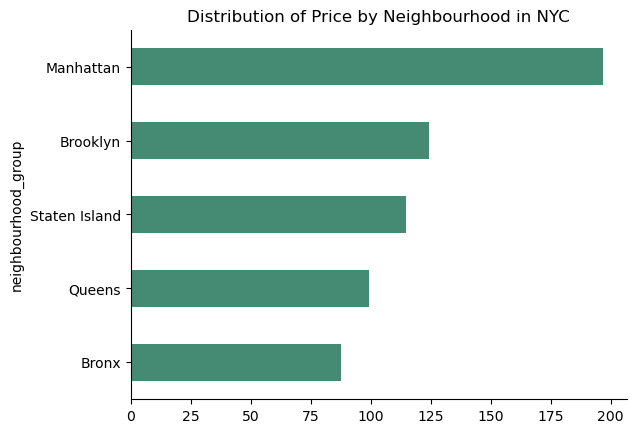

In [137]:
# Plot a barplot on average prices of room types
fig, ax = plt.subplots()
ny2019_airbnb_group_neighbor_full["price"].plot(kind="barh", ax=ax, color='#458B74')

# Specify labels and polishing
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Average Price')
ax.set_ylabel('Neighbourhood')
ax.set_title("Distribution of Price by Neighbourhood in NYC")

The above barplot is a visualization of average price for different neighborhoods, and we can directly visualize that houses in Manhattan are more expensive than other neighborhoods (about two times more expensive than that of Queens and Bronx). Such finding supports that neighborhood is a predictive factor at capturing the variation in house prices, so neighborhood should definitely be involved in regression modeling.

Text(0.5, 1.0, 'Relationship between Price and Number of Reviews')

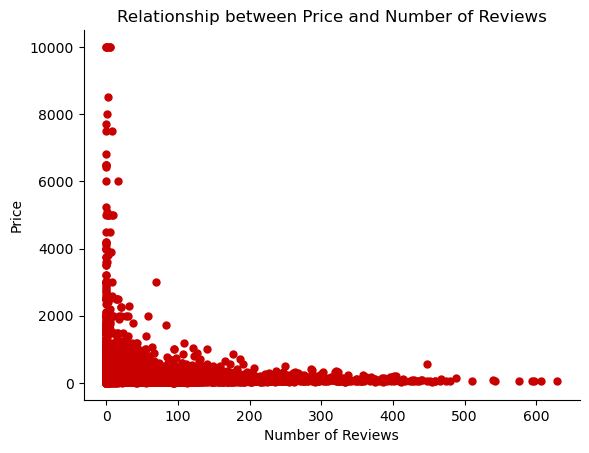

In [171]:
# Plot a scatterplot of price against number of reviews
fig, ax = plt.subplots()
ny2019_airbnb_reg.plot(kind="scatter", x="number_of_reviews", y="price", ax=ax, s=25, color="#c90000")

# Specify labels and polishing
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Number of Reviews')
ax.set_ylabel('Price')
ax.set_title("Relationship between Price and Number of Reviews")

The above scatterplot displays the relationship beween price and the number of reviews for houses offered at Airbnb in 2019. The reason for choosing number of reviews as an explanatory variable is that, houses with more reviews may be more popular, thus more expensive. From the scatterplot, surprisingly, we can discover that as the number of reviews increases, the price tend to decrease on average. This may indicate that more numbers of reviews might somehow reduce the ratings, thus having a negative impact on price. However, even though we can discover a negative trend overall, the concentration of observations at the bottom left corner may indicate that fitting a linear regression model using least squares may not be appropriate since we cannot assume homoskedastic distribution of error.

Text(0.5, 1.0, 'Relationship between Price and Number of Host Listing')

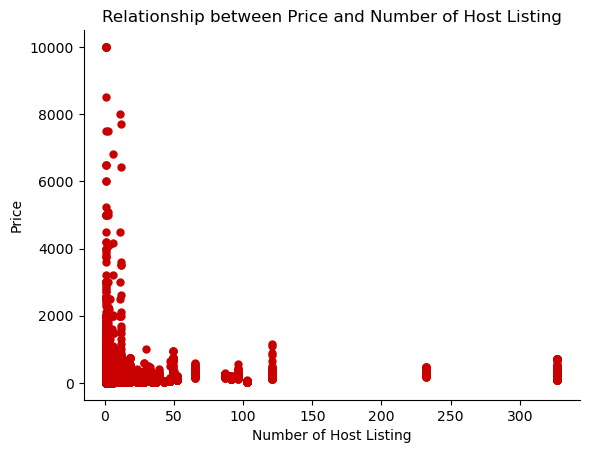

In [173]:
# Plot a scatterplot of price against number of reviews
fig, ax = plt.subplots()
ny2019_airbnb_reg.plot(kind="scatter", x="calculated_host_listings_count", y="price", ax=ax, s=25, color="#c90000")

# Specify labels and polishing
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Number of Host Listing')
ax.set_ylabel('Price')
ax.set_title("Relationship between Price and Number of Host Listing")

The above scatterplot displays the relationship beween price and the number of host listing for houses offered at Airbnb in 2019. Similarly to the number of reviews, the reason for choosing number of host listing as an explanatory variable is that, houses with more host listing may be more popular, thus more expensive. Yet we can discover that, as the number of host listing increases, the price tend to decrease on average. This might indicate that expensive houses do not need that many host listing. However, even though we can discover a negative trend overall, the concentration of observations at the bottom left corner may indicate that fitting a linear regression model using least squares may not be appropriate since we cannot assume homoskedastic distribution of error. Also, the number of host listing, even though it is defined as continuous numerical data, based on the distribution on this plot, there might have been some issues in data collection process where the variation does not seen continuous (spread evenly across the x-axis), which might also post threat to validation in the regression model. 

Text(0.5, 1.0, 'Relationship between Price and Number of Minimum Nights of Stay')

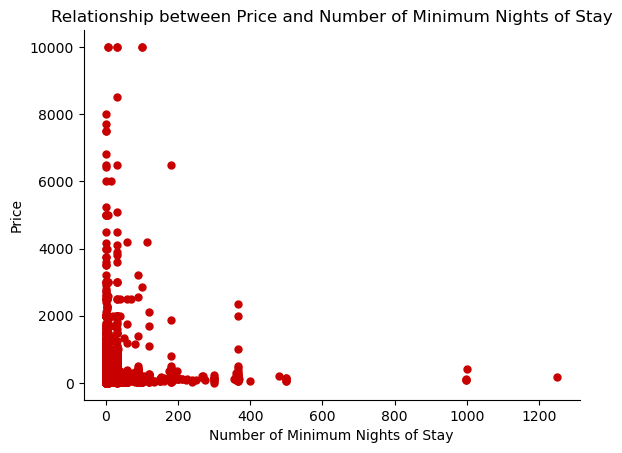

In [172]:
# Plot a scatterplot of price against number of reviews
fig, ax = plt.subplots()
ny2019_airbnb_reg.plot(kind="scatter", x="minimum_nights", y="price", ax=ax, s=25, color="#c90000")

# Specify labels and polishing
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Number of Minimum Nights of Stay')
ax.set_ylabel('Price')
ax.set_title("Relationship between Price and Number of Minimum Nights of Stay")

The above scatterplot displays the relationship beween price and the number of mininun nights of stay for houses offered at Airbnb in 2019. The reason for choosing number of mininun nights as an explanatory variable is that, houses with more minimum nights may be less expensive because it is usual to charge less for longer period of stay. The scatterplot does confirm our intuition, that as the number of minimum nights increases, the price tend to decrease on average. However, even though we can discover a negative trend overall from the position of outliers (dots that are far apart from the majority of dots), the concentration of observations at the bottom left corner may indicate that fitting a linear regression model using least squares may not be appropriate since we cannot assume homoskedastic distribution of error. 

Text(0.5, 1.0, 'Relationship between Price and Number of Available Days')

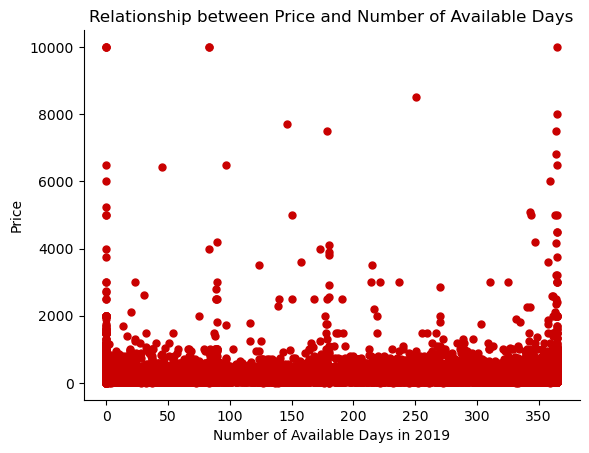

In [174]:
# Plot a scatterplot of price against number of reviews
fig, ax = plt.subplots()
ny2019_airbnb_reg.plot(kind="scatter", x="availability_365", y="price", ax=ax, s=25, color="#c90000")

# Specify labels and polishing
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('Number of Available Days in 2019')
ax.set_ylabel('Price')
ax.set_title("Relationship between Price and Number of Available Days")

The above scatterplot displays the relationship beween price and the number of available days for houses offered at Airbnb in 2019. The reason for choosing number of available days as an explanatory variable is that, houses that are more available might be more accessible and cheaper. However, we can see from the scatterplot that it is difficult to fit a linear line, or any quadratic curves, to capture the trend since observations look like they are randomly spread across the scope. This may support that the availability is not directly correlated with price, and it may not be appropriate to be included in the regression model. 

## Conclusion

To conclude, the purpose of this project is to find what factors may contribute to higher rental prices for New York houses on Airbnb by using Airbnb's open data from New York City in 2019. By generating summarative tables and various forms of plots, we can identify several factors to be positively or negatively correlated with house prices. To be more specific, number of reviews, number of minimun nights of stay, and number of host listings, are negatively correlated with house prices, and the relationship between number of available days in a year and prices is not obvious. Moreover, houses that are more private and larger in size tend to be more expensive, and houses in neighboorhood Manhatten tend to be the most expensive among other neighboorhoods. Even though we need to further testify these claims in the modeling part, these tables and visuals do provide us a good understanding of what directions to take in the future.

The explorative data analysis conducted at this stage also gives insights on what kind of model might be appropriate to fit the data. Since the variances of the response variable (price) and some of the explanatory variables (minimum nights of stay and number of host listong) are quite large and the identification of numbers of outliers, fitting a classic multiple regression model with homoskedastic standard errors might seem inappropriate. In order to make sure the validity of estimation, we may need to implement more advanced methods when fitting, such as heteroskedastic standard errors, or penalized regression models. With the model sufficiently validated, its result can be helpful for researchers and businesses interested in the house rental market, house owners in New York City and future travellors to New York City at summarizing the trend in house rental prices. 